# IMAGE SUPER-RESOLUTION GAN

### Set Up Google Collab

In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/SR-GAN/Data/'
results_path = '/content/drive/My Drive/SR-GAN/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Up Local

In [ ]:
data_path = 'Data/'
results_path = 'Results/'

## Dataset Class + Data Loader

The dataset has been created with the given images from https://data.vision.ee.ethz.ch/cvl/DIV2K/.
Originaly it was composed by: (2k & 4k resolution)

*   Training: 800
*   Validation: 100
*   Test: 100

But we managed to crop the given images so that we can have 10k images (64x64 & 128x128 resolution)

In [2]:
import torch
import torchvision
import scipy.io as sio
import numpy as np

####################################
# 1- Dataset class
####################################
  
class Data_from_mat(torch.utils.data.Dataset):
    
    # Initialization method for the dataset
    def __init__(self, mat_path, data_type="train", transform = None):
        mat_loaded = sio.loadmat(mat_path)        # Load the mat file containing the dataset
        self.type = data_type                     # Set the type of data (train / test)
        self.transform = transform                # Determine a transform if needed
        self.data = np.array(mat_loaded['X'])               # Store the low resolution images in a variable data
        self.label = np.array(mat_loaded['y'])          # Store the high resolution images in a variable label
        
       
    # What to do to load a single item in the dataset ( read image)    
    def __getitem__(self, index):
          data = self.data[index]                  # Get the specified LR image
          data = Image.fromarray(data,mode='RGB')   # transform the LR image to array
          label = self.label[index]                  # Get the specified LR image
          label = Image.fromarray(label,mode='RGB')   # transform the LR image to array
          if self.transform:
              data = self.transform(data)
              label = self.transform(label)
              return (data, label)
    
    
    # Return the number of images
    def __len__(self):
        #print(self.data.shape)
        return self.data.shape[0]

tr = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), # convert image to pytorch tensor [0..,1]
        ])

In [85]:
train_dataset = Data_from_mat(data_path+'Train/dataset_1000.mat', data_type="train", transform = tr)
print("Number of Images: ", train_dataset.__len__())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
print("Number of batches: ", len(train_loader))

(1000, 64, 64, 3)
Number of Images:  1000
Number of batches:  20


### Sample Dataset Image

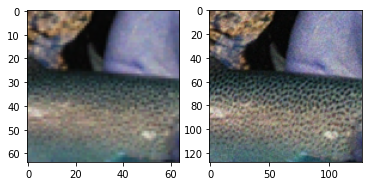

In [8]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Mini-batch images and labels.
images = next(iter(train_loader))

x = images[0]
y = images[1]
LR_RGB = cv2.cvtColor(x[0].permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
HR_RGB = cv2.cvtColor(y[0].permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)

_, _ = plt.subplot(1, 2, 1), plt.imshow(LR_RGB)
_, _ = plt.subplot(1, 2, 2), plt.imshow(HR_RGB)

## Encoder/Decoder 

(1) The **encoder** (Generator) is composed of a first convolutional layer with small 3×3 kernel and 64 feature map, followed by a LReLU activation function (α= 0.2), 7 blocks composed of a convolution + batch normalization + LReLU layers. Each convolutional layer with an increasing number of 3×3 filter kernels, increasing by a factor of 2 from 64 to 512 kernels. (Strided convolutions areused to reduce the image resolution each time the numberof features is doubled)

(2) The **decoder** (Discriminator) is used to estimate for a given Low Resolutin input Image its corresponding HR counterpart.
It is composed of a first convolutional layer with a bigger 9×9 kernel and 64 feature map, followed by a ParametricReLU activation function. After that first block, the tensor is passed through 5 Residual BLocks with identical layout. Each block consists of two convolutional layers with small 3×3 kernels and 64 feature maps followed by batch-normalization layer and a Parametric ReLU as the activation function.
And at the end of it, we use an extra residual block with a single convolutional layer, batch-normalization, and an elementwise sum of the first block. 
An upscaling block is used to increase the size, with 2 trained sub-pixel convolutional layers.

In [4]:
from torch.nn import Module, Linear, Conv2d, BatchNorm2d, PReLU, LeakyReLU, Sequential, PixelShuffle

# 2-Convolution + 2-Batch Normnalization + PReLU + ElementWise Sum for the generator
class residualBlock(Module):
  def __init__(self,in_channels=64, k=3, n=64, s=1):
    super(residualBlock, self).__init__()
    self.rb = Sequential(
        Conv2d(in_channels, n, k, stride=s, padding=1),
        BatchNorm2d(n),
        PReLU(),
        Conv2d(n, n, k, stride=s, padding=1),        
        BatchNorm2d(n)  
    )

  def forward(self,x):
    return self.rb(x) + x

# Convolution + PixelShuffler x2 + PReLU for the generator
class ConvPixelShufflerPReLU(Module):
  def __init__(self,in_channels=64):
    super(ConvPixelShufflerPReLU, self).__init__()

    self.block = Sequential(
        Conv2d(in_channels, in_channels * (2**2), 3, stride=1, padding=1),
        PixelShuffle(2),
        PReLU()
    )
    
  def forward(self ,x):
    return self.block(x)


# Convolution + Batch Normalization + LReLU for the generator
class ConvBNLReLU(Module):
  def __init__(self,in_channels=64, out_channels=64, s=2):
    super(ConvBNLReLU, self).__init__()

    self.block = Sequential(
        Conv2d(in_channels, out_channels, 3, stride=s, padding=1),
        BatchNorm2d(out_channels),
        LeakyReLU(0.2)
    )    
    
  def forward(self ,x):
    return self.block(x)  

class Encoder(Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    self.Block_1 = Sequential(
        Conv2d(3, 64, 9, stride=1, padding=4),
        PReLU()
    )
    
    self.Block_2 = Sequential(
        residualBlock(),
        residualBlock(),
        residualBlock(),
        residualBlock(),
        residualBlock()
    )
    
    self.Block_3 = Sequential(
        Conv2d(64, 64, 3, stride=1, padding=1),
        BatchNorm2d(64)
    )
    
    self.Block_4 = Sequential(
        ConvPixelShufflerPReLU()
        #ConvPixelShufflerPReLU()
    )
    
    self.conv = Conv2d(64, 3, 9, stride=1, padding=4)
  
  def forward(self,x):
    out_1 = self.Block_1(x)
    out = self.Block_2(out_1)
    out = self.Block_3(out) + out_1
    out = self.Block_4(out)
    out = self.conv(out)
    
    out = (torch.tanh(out) + 1) / 2
    return out


class Decoder(Module):
  def __init__(self):
    super(Decoder, self).__init__()
    
    self.discriminator = Sequential(
        Conv2d(3, 64, 3, stride=1, padding=1),
        LeakyReLU(0.2),
        ConvBNLReLU(in_channels=64,  out_channels=64,  s=2), #32x32
        ConvBNLReLU(in_channels=64,  out_channels=128, s=1),
        ConvBNLReLU(in_channels=128, out_channels=128, s=2), #16x16
        ConvBNLReLU(in_channels=128, out_channels=256, s=1),
        ConvBNLReLU(in_channels=256, out_channels=256, s=2), #8x8
        ConvBNLReLU(in_channels=256, out_channels=512, s=1),
        ConvBNLReLU(in_channels=512, out_channels=512, s=2)  #4x4
    )
    
    self.dense_1 = Linear((4*4)*512, 1024)
    self.lrelu = LeakyReLU(0.2)
    self.dense_2 = Linear(1024, 1)
    
  def forward(self,x):
    out = self.discriminator(x)
    #out = torch.flatten(out, start_dim=1, end_dim=-1)
    #out = self.lrelu(self.dense_1(out))
    #out = self.dense_2(out)
    
    return torch.sigmoid(out)

# TRAINING SRGAN


To train our model, we ask the **Generator** to generate a Super Resolution image from a Low Resolution one, and pass it to the **Discriminator** together with the High Resolution image. It will be the discriminator the responsible to guess wich one is the Real.

Our perceptual loss function consist of a **Content Loss** which computes the pixel-wise MSE loss between both images + an **Adversarial Loss**  based  on  the  probabilities  of  the  discriminator.

In [10]:
from datetime import datetime
from torch.nn import MSELoss

def train_GAN(generator, discriminator, train_loader, optimizer_g, optimizer_d,
              num_epochs=10, model_state_name=None, device='cpu'):
    
    model_name = model_state_name
    if not model_name:
        model_name = "state_e"+num_epochs+"_t-"+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+".ckpt"
    
    generator = generator.to(device)
    generator.train() # Set the generator in train mode
    discriminator = discriminator.to(device)
    discriminator.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (LR_images, HR_images) in enumerate(train_loader):

            LR_images = LR_images.to(device)
            HR_images = HR_images.to(device)

            n_images = LR_images.shape[0]

            # Generate SR images
            SR_images = generator.forward(LR_images)
            #print(SR_images.shape, HR_images.shape)


            # Use the discriminator to obtain the probabilties of beeing SR or HR
            prob_HR = discriminator(HR_images).mean()
            prob_SR = discriminator(SR_images).mean()
            

            # Discriminator loss
            disc_loss = 1 - prob_HR + prob_SR
            disc_loss.backward(retain_graph=True)


            # Generator loss
            content_loss = MSELoss()(SR_images, HR_images)
            adversarial_loss = -torch.log(prob_SR).mean()
            gen_loss = content_loss + 0.001*adversarial_loss

            # We are going to update the discriminator and generator parameters alternatively at each iteration

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        
            
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)
        
        # Plot Progress Sample
        LR = LR_images[0].cpu()
        HR = HR_images[0].cpu()
        SR = SR_images[0].cpu()
        LR_RGB = cv2.cvtColor(LR.permute(1,2,0).squeeze().detach().numpy(), cv2.COLOR_BGR2RGB)
        SR_RGB = cv2.cvtColor(SR.permute(1,2,0).squeeze().detach().numpy(), cv2.COLOR_BGR2RGB)
        HR_RGB = cv2.cvtColor(HR.permute(1,2,0).squeeze().detach().numpy(), cv2.COLOR_BGR2RGB)

        _, _ = plt.subplot(1, 3, 1), plt.imshow(LR_RGB)
        _, _ = plt.subplot(1, 3, 2), plt.imshow(SR_RGB)
        _, _ = plt.subplot(1, 3, 3), plt.imshow(HR_RGB)
        plt.show()
    
    return losses_list 

Epoch [1/50], Step [20/20], Gen. Loss: 0.0297, Disc Loss: 0.9927


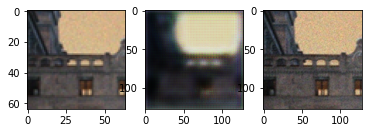

Epoch [2/50], Step [20/20], Gen. Loss: 0.0118, Disc Loss: 0.9744


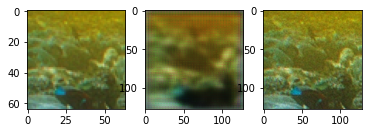

Epoch [3/50], Step [20/20], Gen. Loss: 0.0089, Disc Loss: 0.9843


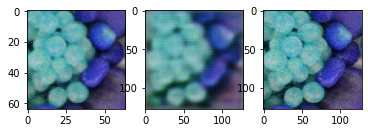

Epoch [4/50], Step [20/20], Gen. Loss: 0.0078, Disc Loss: 0.9839


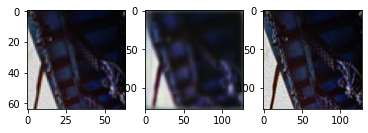

Epoch [5/50], Step [20/20], Gen. Loss: 0.0066, Disc Loss: 0.9834


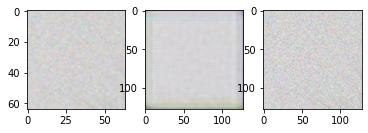

Epoch [6/50], Step [20/20], Gen. Loss: 0.0063, Disc Loss: 0.9841


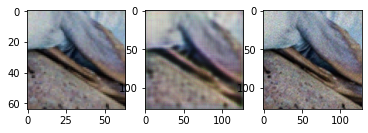

Epoch [7/50], Step [20/20], Gen. Loss: 0.0058, Disc Loss: 0.9733


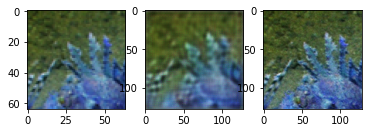

Epoch [8/50], Step [20/20], Gen. Loss: 0.0055, Disc Loss: 0.9648


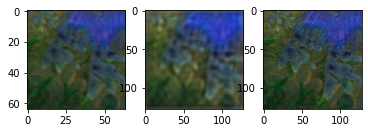

Epoch [9/50], Step [20/20], Gen. Loss: 0.0055, Disc Loss: 0.9708


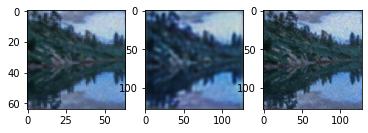

Epoch [10/50], Step [20/20], Gen. Loss: 0.0050, Disc Loss: 0.9622


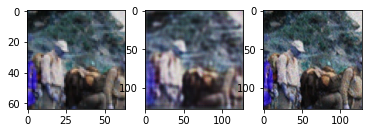

Epoch [11/50], Step [20/20], Gen. Loss: 0.0050, Disc Loss: 0.9619


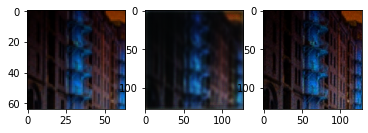

Epoch [12/50], Step [20/20], Gen. Loss: 0.0047, Disc Loss: 0.9662


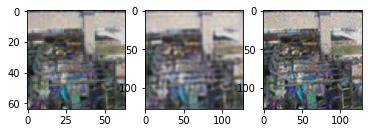

Epoch [13/50], Step [20/20], Gen. Loss: 0.0045, Disc Loss: 0.9561


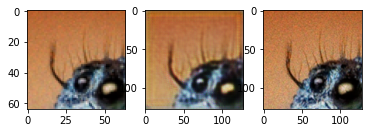

Epoch [14/50], Step [20/20], Gen. Loss: 0.0043, Disc Loss: 0.9493


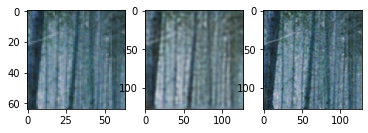

Epoch [15/50], Step [20/20], Gen. Loss: 0.0041, Disc Loss: 0.9594


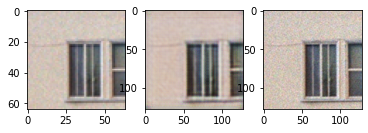

Epoch [16/50], Step [20/20], Gen. Loss: 0.0040, Disc Loss: 0.9581


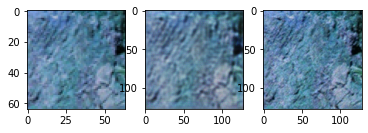

Epoch [17/50], Step [20/20], Gen. Loss: 0.0045, Disc Loss: 0.9519


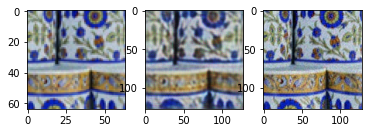

Epoch [18/50], Step [20/20], Gen. Loss: 0.0038, Disc Loss: 0.9431


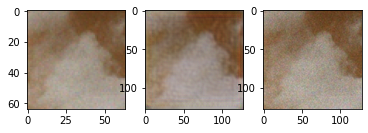

Epoch [19/50], Step [20/20], Gen. Loss: 0.0036, Disc Loss: 0.9394


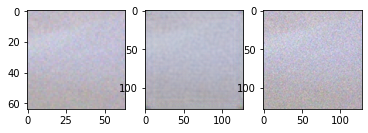

Epoch [20/50], Step [20/20], Gen. Loss: 0.0037, Disc Loss: 0.9416


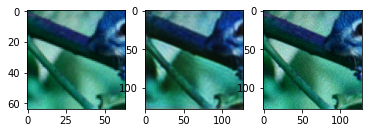

Epoch [21/50], Step [20/20], Gen. Loss: 0.0037, Disc Loss: 0.9383


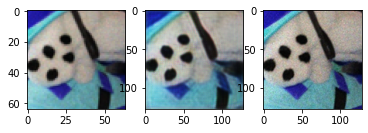

Epoch [22/50], Step [20/20], Gen. Loss: 0.0038, Disc Loss: 0.9324


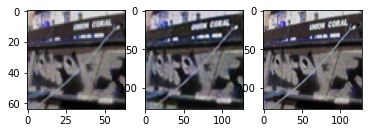

Epoch [23/50], Step [20/20], Gen. Loss: 0.0037, Disc Loss: 0.9307


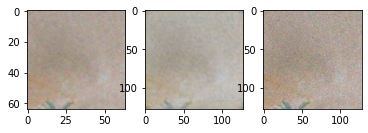

Epoch [24/50], Step [20/20], Gen. Loss: 0.0034, Disc Loss: 0.9303


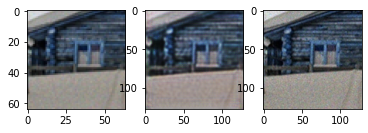

Epoch [25/50], Step [20/20], Gen. Loss: 0.0034, Disc Loss: 0.9308


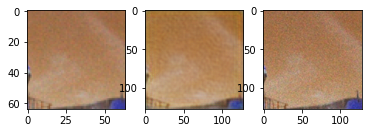

Epoch [26/50], Step [20/20], Gen. Loss: 0.0032, Disc Loss: 0.9265


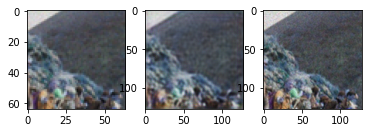

Epoch [27/50], Step [20/20], Gen. Loss: 0.0031, Disc Loss: 0.9311


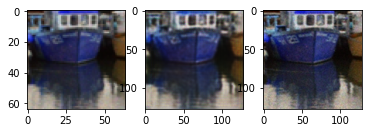

Epoch [28/50], Step [20/20], Gen. Loss: 0.0033, Disc Loss: 0.9505


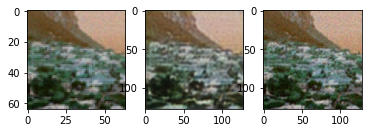

Epoch [29/50], Step [20/20], Gen. Loss: 0.0033, Disc Loss: 0.9610


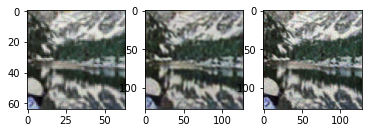

Epoch [30/50], Step [20/20], Gen. Loss: 0.0035, Disc Loss: 0.9316


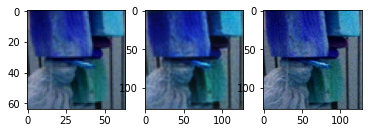

Epoch [31/50], Step [20/20], Gen. Loss: 0.0035, Disc Loss: 0.9327


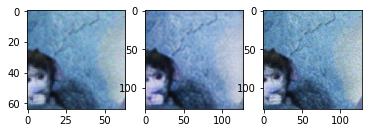

Epoch [32/50], Step [20/20], Gen. Loss: 0.0032, Disc Loss: 0.9399


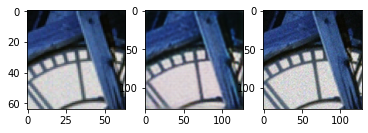

Epoch [33/50], Step [20/20], Gen. Loss: 0.0033, Disc Loss: 0.9544


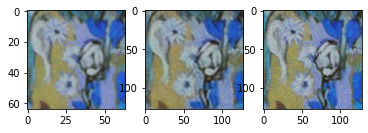

Epoch [34/50], Step [20/20], Gen. Loss: 0.0032, Disc Loss: 0.9598


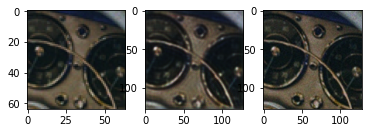

Epoch [35/50], Step [20/20], Gen. Loss: 0.0033, Disc Loss: 0.9806


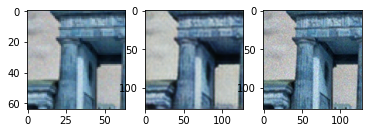

Epoch [36/50], Step [20/20], Gen. Loss: 0.0030, Disc Loss: 0.9744


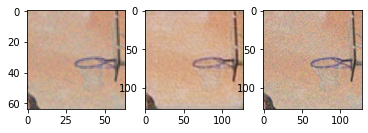

Epoch [37/50], Step [20/20], Gen. Loss: 0.0031, Disc Loss: 0.9903


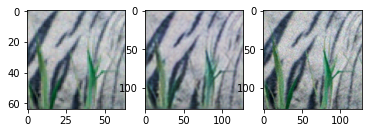

Epoch [38/50], Step [20/20], Gen. Loss: 0.0029, Disc Loss: 0.9788


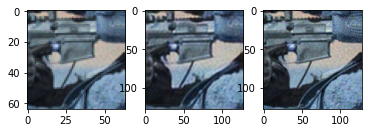

Epoch [39/50], Step [20/20], Gen. Loss: 0.0029, Disc Loss: 0.9610


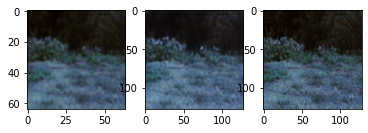

Epoch [40/50], Step [20/20], Gen. Loss: 0.0029, Disc Loss: 0.9500


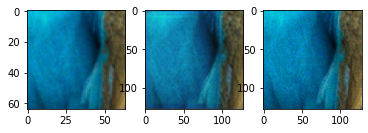

Epoch [41/50], Step [20/20], Gen. Loss: 0.0031, Disc Loss: 0.9474


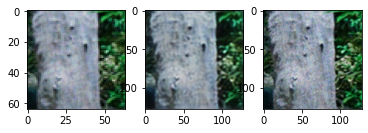

Epoch [42/50], Step [20/20], Gen. Loss: 0.0030, Disc Loss: 0.9329


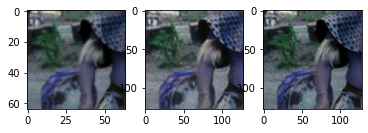

Epoch [43/50], Step [20/20], Gen. Loss: 0.0030, Disc Loss: 0.9297


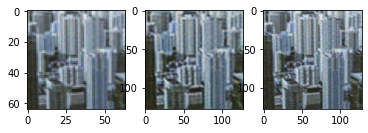

Epoch [44/50], Step [20/20], Gen. Loss: 0.0031, Disc Loss: 0.9265


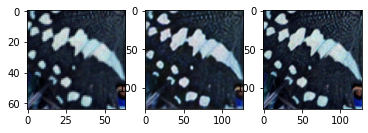

Epoch [45/50], Step [20/20], Gen. Loss: 0.0030, Disc Loss: 0.9255


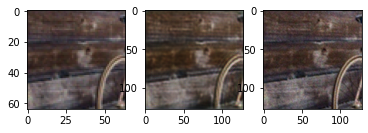

Epoch [46/50], Step [20/20], Gen. Loss: 0.0029, Disc Loss: 0.9420


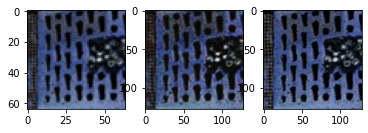

Epoch [47/50], Step [20/20], Gen. Loss: 0.0028, Disc Loss: 0.9707


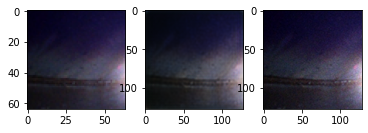

Epoch [48/50], Step [20/20], Gen. Loss: 0.0029, Disc Loss: 0.9569


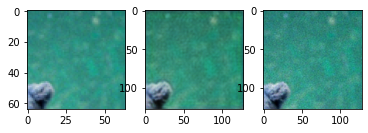

Epoch [49/50], Step [20/20], Gen. Loss: 0.0027, Disc Loss: 0.9493


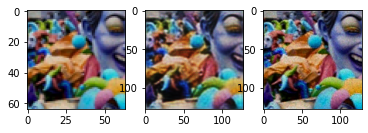

Epoch [50/50], Step [20/20], Gen. Loss: 0.0027, Disc Loss: 0.9395


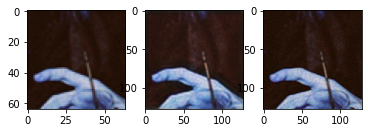

In [11]:
# Define Geneartor and Discriminator networks
gan_gen = Encoder()
gan_disc = Decoder()

#Initialize indepdent optimizer for both networks
learning_rate = .0005
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = 1E-4)#, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = 1E-4)#, weight_decay=1e-5)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc,
                      num_epochs=50, model_state_name='Test.ckpt', device=device)

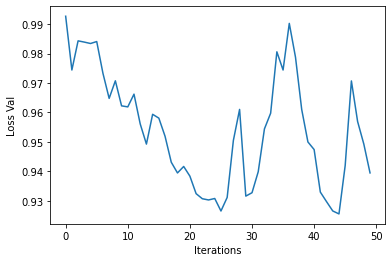

In [12]:
# Plot the evolution of the loss function during training
plt.plot(loss_list, label="Train")
plt.xlabel('Iterations')
plt.ylabel('Loss Val')
plt.show()

#TESTING SRGAN

Once our model has been trained, we can Test the resoults by using the generated CKPT file.
To do so we create another Data class which loads LR images never seen by our model.

In [ ]:
# Load the Test Dataset from th e specified .mat

test_dataset = Data_from_mat(data_path+'Test/dataset_random.mat', data_type="test", transform = tr)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100)

print("Number of Images: ", test_dataset.__len__())
print("Number of batches: ", len(test_loader))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load generator
gan_gen = Encoder()
gan_gen.load_state_dict(torch.load(results_path+'Test.ckpt'))
gan_gen.eval() # Put in eval model
gan_gen = gan_gen.to(device)

img index: 94


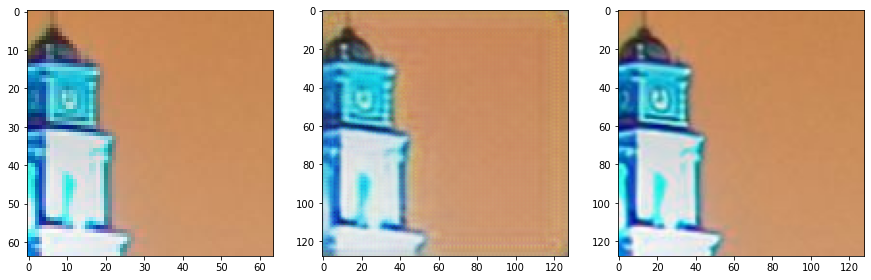

In [17]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random

# Mini-batch images and labels.
images = next(iter(test_loader))

LR = images[0]
HR = images[1]
SR = gan_gen.forward(LR.to(device))


indx = random.randint(0, 100)
print("img index:", indx) 

LR_RGB = cv2.cvtColor(LR[indx].permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)
SR_RGB = cv2.cvtColor(SR[indx].cpu().permute(1,2,0).squeeze().detach().numpy(), cv2.COLOR_BGR2RGB)
HR_RGB = cv2.cvtColor(HR[indx].permute(1,2,0).squeeze().numpy(), cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(2, 2, figsize=(15,15))
_, _ = plt.subplot(1, 3, 1), plt.imshow(LR_RGB)
_, _ = plt.subplot(1, 3, 2), plt.imshow(SR_RGB)
_, _ = plt.subplot(1, 3, 3), plt.imshow(HR_RGB)
